# Lab RNN

Aim is to build a basic RNN model for classificaiton of emotions.

Solution inspired by:
* https://www.kaggle.com/code/anetakovacheva/classifying-emotions-with-a-rnn
* https://www.tensorflow.org/tutorials/keras/text_classification

*Note that current lab is not aiming at defining optimal model. Focus is rather on roughly exploring some basic concepts using very limited hardvare resources (CPU)*

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# preprocess text
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

# deep ML
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers

[nltk_data] Downloading package stopwords to /home/dorota/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/dorota/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Help functions and settings

In [28]:
def count_words_in_df(text):
    '''Count total number of words in dataframe'''
    rows = text.apply(lambda row: row.split(' ')) # create a list of words for each row
    word_count = [word for row in rows for word in row] # concatinate all words from whole df into one list
    word_uniqe = set(word_count)
    return len(word_count), len(word_uniqe)


def remove_stop_words_and_lemmatize(text, lemmatizer):
    '''Removes stop words and lemmatizes text (nouns and verbs)'''
    words = text.split(' ')
    words_cleaned = [lemmatizer.lemmatize(word) for word in words if word not in set(stopwords.words('english'))] # lemmatize nouns
    words_cleaned = [lemmatizer.lemmatize(word, pos='v') for word in words_cleaned] # lemmatize verbs
    text_cleaned = (' ').join(words_cleaned)
    return text_cleaned

def plot_training_history(train_losses, train_accuracies, val_losses, val_accuracies, test_loss, test_accuracy):
    plt.figure(figsize=(10, 3))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.title(f'Loss (test loss = {test_loss:.4f})')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracies, label='train')
    plt.plot(val_accuracies, label='val')
    plt.title(f'Accuracy (test accuracy = {test_accuracy:.4f})')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')

    plt.legend()
    plt.show()


def display_confusion_matrix(y_pred, y_test, labels_dict):
    labels_list = list(labels_dict.keys())
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_test_classes = np.argmax(y_test, axis=1)
    # Confusion Matrix
    cm = confusion_matrix(y_test_classes, y_pred_classes)
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=labels_list, yticklabels=labels_list)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

In [3]:
pd.set_option('display.max_colwidth', None)

---
---

## Data and EDA

In [4]:
df = pd.read_csv('./data/emotions.csv')

In [5]:
df

,text,label
0,i feel so pissed off over an old friend and some friends,anger
1,ive found it has made a huge difference especially on the finger with my ring and the my skin feels so much softer and less irritated,anger
2,i also feel it is unfortunate that nearly all the readers of going to meet the man will be african americans unlike myself,sadness
3,i feel petty a href http clairee,anger
4,i used to believe that a feeling like fear was to be ignored or suppressed right away more on this in a moment,sadness
...,...,...
19995,i was i might be buying stuff from there but i feel the clothes are too casual,joy
19996,i like sonam deepika and genelia who i feel are very talented and beautiful,joy
19997,i feel pathetic that i can hardly go a whole day not talking to him,sadness
19998,id have spent more time with her on reading i feel a bit guilty about that,sadness


In [6]:
df.label.value_counts()

label
joy         6761
sadness     5797
anger       2709
fear        2373
love        1641
surprise     719
Name: count, dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    20000 non-null  object
 1   label   20000 non-null  object
dtypes: object(2)
memory usage: 312.6+ KB


* Data contains 6 emotion labels, where distribution is not fully balanced.
* Total of 20000 entries. No missing values.
* All text is alread in lower case. Dot, comma etc has been removed. Remaining is removal of stopwords and lemmatization.
---

## Data pre-processing

#### Remove stop words, lemmatize text, quantify words and sequence lenth

In [8]:
lemmatizer = WordNetLemmatizer()

In [9]:
word_tot, words_uniqe = count_words_in_df(df.text)
print(f'Dataset contains {word_tot} words prior to removal of stopwords, where {words_uniqe} are unique')
df.text = df.text.apply(lambda row_text: remove_stop_words_and_lemmatize(row_text, lemmatizer))
word_tot, words_uniqe = count_words_in_df(df.text)
print(f'Dataset contains {word_tot} words after removal of stopwords, where {words_uniqe} are unique')

Dataset contains 382701 words prior to removal of stopwords, where 17096 are unique
Dataset contains 186657 words after removal of stopwords, where 12779 are unique


In [10]:
df

,text,label
0,feel piss old friend friend,anger
1,ive find make huge difference especially finger ring skin feel much softer le irritate,anger
2,also feel unfortunate nearly reader go meet man african american unlike,sadness
3,feel petty href http clairee,anger
4,use believe feel like fear ignore suppress right away moment,sadness
...,...,...
19995,might buy stuff feel clothe casual,joy
19996,like sonam deepika genelia feel talented beautiful,joy
19997,feel pathetic hardly go whole day talk,sadness
19998,id spend time read feel bite guilty,sadness


In [11]:
max_length = df.text.apply(lambda row: len(row.split(' '))).max()
print(f'Longest sentence is {max_length} words')

Longest sentence is 35 words


#### Make arrays, one-hot encode labels, split into train|val|test

In [12]:
X_array = df.text.to_numpy()

In [13]:
labels_dict = {"anger": 0, "fear": 1, "joy": 2, "love": 3, "sadness": 4, "surprise": 5}

df.label = df.label.replace(labels_dict) # str -> int
y_array = df.label.to_numpy() # pd.Series -> array
y_array = to_categorical(y_array, len(labels_dict)) # one-hot encoding

In [14]:
X_trainval, X_test, y_trainval, y_test =train_test_split(X_array, y_array, test_size=0.20, random_state=42)
X_train, X_val, y_train, y_val =train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=42)

X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((12000,), (4000,), (4000,), (12000, 6), (4000, 6), (4000, 6))

#### Tokenize and padd text

In [ ]:
vocab_size = 13000    # dataset contains 12779 unique words
max_length = 40    # maximum sentence lenth is 35 words but assuming future datapoint could be somewhat longer without truncation

vectorize_layer = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=max_length)

# preprocessing of text can as alternative be done in the TextVectorization (lower_case, remove punctuation, custom processing functions)

In [16]:
# build vocabulary based on X_train
vectorize_layer.adapt(X_train)

# vocabulary can be listed with vectorize_layer.get_vocabulary()

In [17]:
# tokenize X_train, X_val and X_test (arrays -> tensors with padding up to max_length)
X_train_tokenized = vectorize_layer(X_train)
X_val_tokenized = vectorize_layer(X_val)
X_test_tokenized = vectorize_layer(X_test)

X_train_tokenized.shape, X_val_tokenized.shape, X_test_tokenized.shape

(TensorShape([12000, 40]), TensorShape([4000, 40]), TensorShape([4000, 40]))

---

## Build and evaluate model
GRU and LSTM are tested in a very simple architecture. SimpleRNN is not evaluated



In [18]:
embedding_dim = 32

#### GRU

In [19]:
# NOTE: vectorize_layer can be added pror to Embedding layer directly in the model
model_gru = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])
model_gru.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [20]:
model_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 32)            416000    
                                                                 
 gru (GRU)                   (None, 128)               62208     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 486854 (1.86 MB)
Trainable params: 486854 (1.86 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


125/125 - 1s - loss: 0.2353 - accuracy: 0.9082 - 1s/epoch - 11ms/step


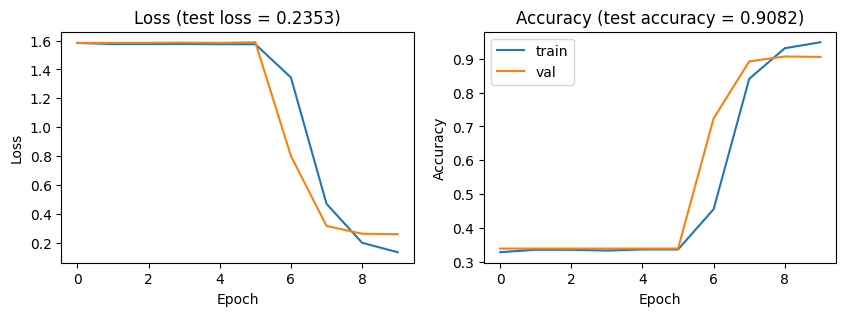

In [21]:
history = model_gru.fit(X_train_tokenized, y_train, epochs=10, validation_data=(X_val_tokenized, y_val), verbose=0)
train_loss, train_accuracy, val_loss, val_accuracy = history.history.values()
test_loss, test_accuracy = model_gru.evaluate(X_test_tokenized, y_test, verbose=2)
plot_training_history(train_loss, train_accuracy, val_loss, val_accuracy, test_loss, test_accuracy)

  8/125 [>.............................] - ETA: 2s

125/125 [==============================] - 2s 15ms/step


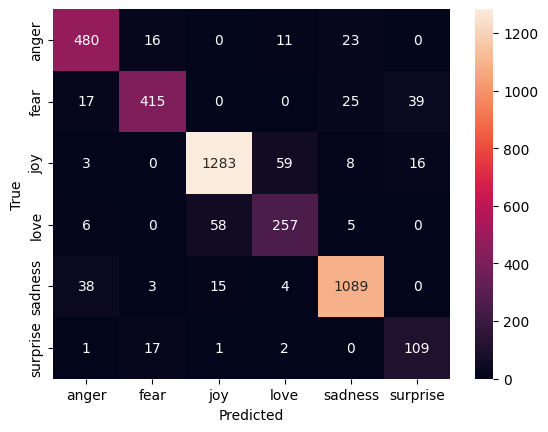

In [36]:
y_pred = model_gru.predict(X_test_tokenized)
display_confusion_matrix(y_pred, y_test, labels_dict)

#### LSTM

In [38]:
# NOTE: vectorize_layer can be added pror to Embedding layer directly in the model
model_lstm = tf.keras.models.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax')
])

model_lstm.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

125/125 - 4s - loss: 0.4093 - accuracy: 0.8760 - 4s/epoch - 28ms/step


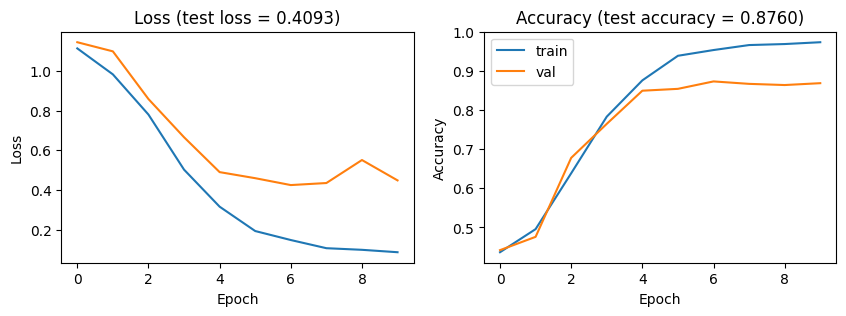

In [40]:
history = model_lstm.fit(X_train_tokenized, y_train, epochs=10, validation_data=(X_val_tokenized, y_val), verbose=0)
train_loss, train_accuracy, val_loss, val_accuracy = history.history.values()
test_loss, test_accuracy = model_lstm.evaluate(X_test_tokenized, y_test, verbose=2)
plot_training_history(train_loss, train_accuracy, val_loss, val_accuracy, test_loss, test_accuracy)

125/125 [==============================] - 3s 22ms/step


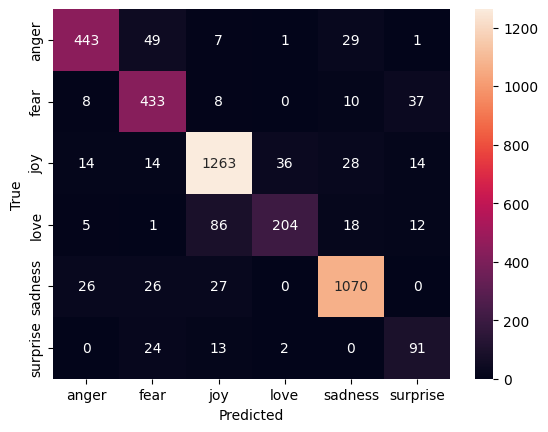

In [41]:
y_pred = model_lstm.predict(X_test_tokenized)
display_confusion_matrix(y_pred, y_test, labels_dict)

---
#### Conclusions and comments:
Very simple GRU model yealds 90% accuracy on test dat. Love/joy are most difficult to distinguish between. Also fear/surprise and fear/sadness.\
LSTM did not improve performance, which might be expected considering input text being relatively short.

#### Questions:

Model architecture:
* Simplest possible network with parameters for:
    * categorical crossentropy as loss function whichis suitable for multiclassification problem
    * go to opimizer Adam
    * GRU with dim 128
    * 1 dense layers after GRU with relu activation
    * 1 output dense layer with output dim 6 corresponding to the 6 emotions and softmax which is suitable for multiclassification
    * no initial regularization, however would be useful to reduce overfitting
* To improve performance hyperpareameter to be tuned could be for example:
    * larger embeddings dimensions
    * more/deeper layers after GRU
    * GRU dimension
    * introduction regularization (L2)
    * introduction of drop-ut layers

Data was already in lowercase with no punctuation. Further pre-treatment included removal of stop words and lemmatization of nouns and verbs. Size of total vocuabulary was thus reduced by 50% where uniqe words were reduced from 17 k to 14 k.\
Model was evaluated by tracking loss and accuracy during training and by summarizing results in a confusion matrix to draw conclusions.\
Performance is fairly good considering the simplicity of the model. To improve hyperparameter tuning and looking closer into samples with love/joy could be tested.


Question: Describe the difference between generative AI and more traditional AI\
Traditional AI focuses on understanding patterns in data to eventually be able to make decisions or predictions for new data within a dataset with common rules/patterns. It relies on algoritms and rules defined by experts based on their domain knowledge. Generative AI can create new data based on the data it has been trained on.